<a href="https://colab.research.google.com/github/huiqin97/Deep-Learning-in-Learning-Analysis/blob/main/FinalVersion_FFN_%26_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import all necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Dropout

from keras import Input, layers
from keras.layers import Concatenate
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Load the demographic and VLE data from the OULAD
students = pd.read_csv('https://raw.githubusercontent.com/huiqin97/Deep-Learning-in-Learning-Analysis/main/studentInfo.csv')
vle= pd.read_csv('https://raw.githubusercontent.com/huiqin97/Deep-Learning-in-Learning-Analysis/main/vle.csv')
svle=pd.read_csv('/content/drive/MyDrive/studentVle.csv')

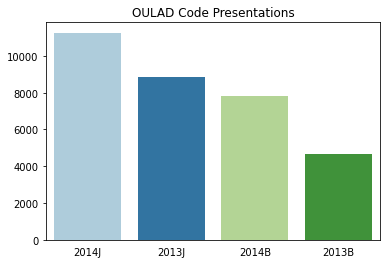

In [ ]:
sns.countplot('code_presentation',data=students,order = students['code_presentation'].value_counts().index,palette='Paired')
plt.ylabel('')
plt.xlabel(' ')
plt.title('OULAD Code Presentations')
plt.tick_params(bottom=False)

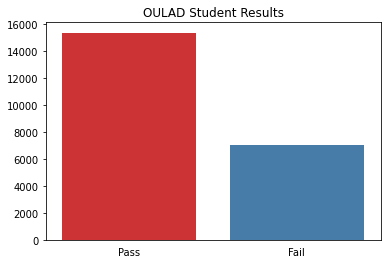

In [ ]:
cat= ['Pass','Fail','Distinction']
students =students[students['final_result'].isin(cat)]
students.final_result = students.final_result.apply(lambda x: x  if x=='Fail' else 'Pass')
sns.countplot('final_result',data=students,palette='Set1')
plt.ylabel('')
plt.xlabel(' ')
plt.title('OULAD Student Results')
plt.tick_params(bottom=False)

In [ ]:
#class distribution
students.final_result.value_counts()

Pass    15385
Fail     7052
Name: final_result, dtype: int64

In [ ]:
students.final_result = students.final_result.apply(lambda x: 1 if x=="Pass" else 0)

The result is biased toward Pass, so will need to use oversampling using SMOTE

Pre-Processing of VLE data

In [ ]:
date_to_be_mapped =svle.date.unique()
date_week_mapping ={}

In [ ]:
# map the date to its respectiev week number
date_week_mapping[0]=0
for date in date_to_be_mapped:
    start =1
    end =7
    for week in range(0,39):
        if date>0:                                        # Check for date after course starts
            if date >= start and date<=end:
                date_week_mapping[date]= week
                break 
        else:                                             # Check for date where student access the course before it starts
            temp_date = -date
            if temp_date >= start and temp_date<=end:
                date_week_mapping[date]= -(week+1)
                break 
        start= start+ 7 
        end = end +7

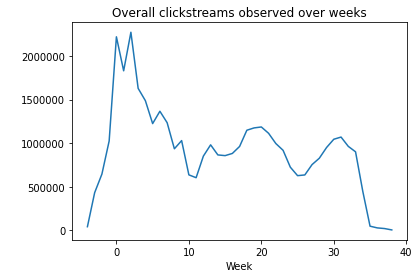

In [ ]:
# Add the week Column to the dataframe
svle['week']= svle.date.apply(lambda x : date_week_mapping[x])
# clickstreams pattern observed over the 38 weeks
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
svle.groupby('week').sum_click.sum().plot(kind="line",ax=ax)
plt.xlabel('Week')
plt.ylabel(' ')
plt.title('Overall clickstreams observed over weeks')
ax.ticklabel_format(useOffset=False, style='plain')
plt.show()

In [ ]:
merged_data =pd.merge(svle,students,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))
passed_cases=merged_data[merged_data.final_result==1]
fail_cases=merged_data[merged_data.final_result==0]

Clickstream for Pass and Fail Over 38 weeks

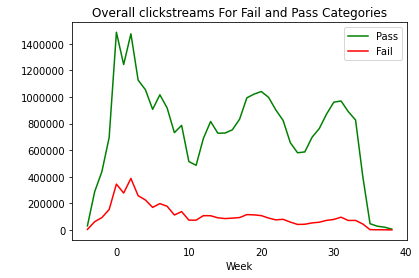

In [ ]:
# clickstreams pattern observed over the 38 weeks for both the categories
fig, ax = plt.subplots()
passed_cases.groupby(['week']).sum_click.sum().plot(kind="line",ax=ax,color='green',label="Pass")
fail_cases.groupby(['week']).sum_click.sum().plot(kind="line",ax=ax,color='red',label="Fail")
plt.xlabel('Week')
plt.ylabel(' ')
plt.legend()
plt.title('Overall clickstreams For Fail and Pass Categories')
ax.ticklabel_format(useOffset=False, style='plain')
plt.tick_params(bottom=False)

In [ ]:
print("               Overall Analysis Statistics              ")
print("")
print("Total Withdraw Clicks:              ", fail_cases['sum_click'].sum())
print("Total Pass Clicks:                  ", passed_cases['sum_click'].sum())
print("Student count in Pass category      ", passed_cases.id_student.nunique())
print("Student count in Fail category ", fail_cases.id_student.nunique())

               Overall Analysis Statistics              

Total Withdraw Clicks:               4596865
Total Pass Clicks:                   31819757
Student count in Pass category       14578
Student count in Fail category  6456


In [ ]:
data = svle.groupby(['code_module','code_presentation','id_student','week']).sum_click.sum().reset_index()
data.head(5)


,code_module,code_presentation,id_student,week,sum_click
0,AAA,2013J,11391,-1,98
1,AAA,2013J,11391,0,183
2,AAA,2013J,11391,1,20
3,AAA,2013J,11391,2,100
4,AAA,2013J,11391,4,26


Details of each student with their respective courses along 38 weeks

In [ ]:
week_processed =data.reset_index().groupby(['code_module','code_presentation','id_student','week'])['sum_click'].aggregate('first').unstack().reset_index()
week_processed.fillna(0,inplace=True)
week_processed.head(3)

week,code_module,code_presentation,id_student,-4,-3,-2,-1,0,1,2,...,29,30,31,32,33,34,35,36,37,38
0,AAA,2013J,11391,0.0,0.0,0.0,98.0,183.0,20.0,100.0,...,43.0,0.0,35.0,15.0,0.0,92.0,0.0,1.0,0.0,0.0
1,AAA,2013J,28400,0.0,0.0,79.0,136.0,182.0,59.0,37.0,...,21.0,88.0,16.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,AAA,2013J,30268,0.0,0.0,14.0,88.0,107.0,72.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Combine demographic with VLE

In [ ]:
student_week_data=  pd.merge(students,week_processed,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))
student_week_data.head(5)

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,...,29,30,31,32,33,34,35,36,37,38
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,...,43.0,0.0,35.0,15.0,0.0,92.0,0.0,1.0,0.0,0.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,...,21.0,88.0,16.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,...,26.0,31.0,51.0,85.0,5.0,105.0,13.0,1.0,2.0,0.0
3,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,...,6.0,0.0,71.0,20.0,20.0,3.0,7.0,0.0,0.0,0.0
4,AAA,2013J,38053,M,Wales,A Level or Equivalent,80-90%,35-55,0,60,...,67.0,218.0,284.0,21.0,42.0,69.0,32.0,1.0,5.0,1.0


VLE activity

Text(0.5, 1.0, 'Frequency across different VLE platform')

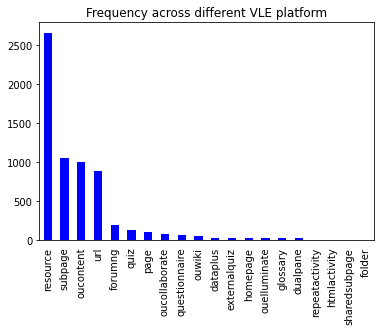

In [ ]:
vle.activity_type.value_counts().plot(kind='bar',color="blue")
plt.tick_params(bottom=False)
plt.title('Frequency across different VLE platform')

Combine VLE activity with Student VLE

In [ ]:
res_vle=  pd.merge(svle,vle,how='inner',left_on=("code_module","code_presentation","id_site"),right_on=("code_module","code_presentation","id_site"))
res_vle.drop(['week_from','week_to'],axis=1,inplace=True)
res_vle.head(3)

,code_module,code_presentation,id_student,id_site,date,sum_click,week,activity_type
0,AAA,2013J,28400,546652,-10,4,-2,forumng
1,AAA,2013J,28400,546652,-10,1,-2,forumng
2,AAA,2013J,28400,546652,-10,1,-2,forumng


In [ ]:
res_vle_w = res_vle[res_vle.week<=5]
stud_week_material = res_vle_w.groupby(['code_module','code_presentation','id_student','week','activity_type']).sum_click.sum().reset_index()
student_material = stud_week_material.groupby(['code_module','code_presentation','id_student','activity_type']).sum_click.sum().reset_index()
resource_processed =student_material.reset_index().groupby(['code_module','code_presentation','id_student','activity_type'])['sum_click'].aggregate('first').unstack().reset_index()
resource_processed.fillna(0,inplace=True)
resource_processed.head(5)

activity_type,code_module,code_presentation,id_student,dataplus,dualpane,externalquiz,forumng,glossary,homepage,htmlactivity,...,oucontent,ouelluminate,ouwiki,page,questionnaire,quiz,resource,sharedsubpage,subpage,url
0,AAA,2013J,11391,0.0,0.0,0.0,80.0,0.0,58.0,0.0,...,316.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,23.0,1.0
1,AAA,2013J,28400,0.0,0.0,0.0,209.0,0.0,137.0,0.0,...,183.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,60.0,31.0
2,AAA,2013J,30268,0.0,0.0,0.0,126.0,0.0,59.0,0.0,...,66.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,22.0,4.0
3,AAA,2013J,31604,0.0,0.0,0.0,178.0,1.0,139.0,0.0,...,263.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,66.0,28.0
4,AAA,2013J,32885,0.0,0.0,0.0,138.0,2.0,107.0,0.0,...,313.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,28.0,6.0


In [ ]:
resource_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28973 entries, 0 to 28972
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        28973 non-null  object 
 1   code_presentation  28973 non-null  object 
 2   id_student         28973 non-null  int64  
 3   dataplus           28973 non-null  float64
 4   dualpane           28973 non-null  float64
 5   externalquiz       28973 non-null  float64
 6   forumng            28973 non-null  float64
 7   glossary           28973 non-null  float64
 8   homepage           28973 non-null  float64
 9   htmlactivity       28973 non-null  float64
 10  oucollaborate      28973 non-null  float64
 11  oucontent          28973 non-null  float64
 12  ouelluminate       28973 non-null  float64
 13  ouwiki             28973 non-null  float64
 14  page               28973 non-null  float64
 15  questionnaire      28973 non-null  float64
 16  quiz               289

FeedForward Neural Network with student demographic, vle and student vle activities data

In [ ]:
from imblearn.over_sampling import SMOTE


The defination of model is here

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

In [ ]:
METRICS =[
    keras.metrics.AUC(name ='accuracy'),
    keras.metrics.Recall(name ='recall'),
    keras.metrics.Precision(name = 'precision'),
]

def model_architecture(nodes):
    model= Sequential()
    model.add(Dense(10,activation='relu',input_dim=nodes))
    model.add(Dense(6,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)
    return model

In [ ]:
#10 fold cross validation for the Feed Forward Neural Network
def cross_val_feed_forward(x_tr,y_tr,input_size):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    cvscores = []
    cv_fscores= []

    for train, test in kfold.split(x_tr, y_tr):
        model = model_architecture(input_size)
        model.fit(x_tr[train], y_tr[train], epochs=10, batch_size=32, verbose=0)

        y_test_rev= model.predict(x_tr[test])
        y_test_rev= [1 if y>=0.5 else 0 for y in y_test_rev]
        
        fscr =f1_score(y_test_rev,y_tr[test])
        cvscores.append(accuracy_score(y_test_rev,y_tr[test]))
        cv_fscores.append(fscr)
    
    return np.mean(cvscores)*100, np.mean(cv_fscores)

In [ ]:
def vle_week_resource_ann_analysis(res_vle,week_selection,week_no, if_smote):
    
    res_vle_w = res_vle[res_vle.week<=week_selection]
    stud_week_material = res_vle_w.groupby(['code_module','code_presentation','id_student','week','activity_type']).sum_click.sum().reset_index()
    student_material = stud_week_material.groupby(['code_module','code_presentation','id_student','activity_type']).sum_click.sum().reset_index()
    resource_processed =student_material.reset_index().groupby(['code_module','code_presentation','id_student','activity_type'])['sum_click'].aggregate('first').unstack().reset_index()
    resource_processed.fillna(0,inplace=True)
    student_res_data=  pd.merge(students,resource_processed,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))
    stu_resr_data=student_res_data.copy()
    stu_resr_data['code_presentation']=stu_resr_data.code_presentation.apply(lambda x: str(x)[-1])
    
    r_df = pd.get_dummies(stu_resr_data, columns=['code_module','code_presentation','gender', 'region', 'highest_education','imd_band','age_band','disability'],drop_first=True)
    y = r_df.final_result.values
    X = r_df.drop(['final_result','id_student'],axis=1).values
    x_train_d , x_test_d , y_train_d , y_test_d = train_test_split(X,y, test_size=0.25,random_state=0)
    
    sc=StandardScaler()
    x_train_d=sc.fit_transform(x_train_d)
    x_test_d=sc.transform(x_test_d)     
    
    model= model_architecture(x_train_d.shape[1])
    if(week_selection == 15):
      model.save('path/to/location')
   
    if(if_smote):
        sm = SMOTE(random_state=1)
        x_train_d, y_train_d = sm.fit_resample(x_train_d, y_train_d.ravel())
    fold_acc, fold_fscore = cross_val_feed_forward(x_train_d,y_train_d,x_train_d.shape[1])

    model.fit(x_train_d,y_train_d,batch_size=32,epochs=10,verbose=0)
    y_pred= model.predict(x_test_d)
    y_pred=[1 if y >=0.5 else 0 for y in y_pred]
    
    print("Week",week_no,"  Accuracy: %.2f  F-Score:  %.3f" % (accuracy_score(y_test_d,y_pred)*100, f1_score(y_test_d,y_pred)) ,"\t10-fold  Accuracy %.3f\tF-Score:  %.3f" %(fold_acc,fold_fscore))

Model Training without SMOTE

In [ ]:
print("\t\t\tClickstreams Aggregated by VLE Materials with Student Demographic")
print()
print("   Feed Forward Neural Network Results Without SMOTE  ")
print()
vle_week_resource_ann_analysis(res_vle,5,'05',False)
vle_week_resource_ann_analysis(res_vle,10,'10',False)
vle_week_resource_ann_analysis(res_vle,15,'15',False)
vle_week_resource_ann_analysis(res_vle,20,'20',False)
vle_week_resource_ann_analysis(res_vle,25,'25',False)

			Clickstreams Aggregated by VLE Materials with Student Demographic

   Feed Forward Neural Network Results Without SMOTE  

171/171 [==============================] - 0s 1ms/step
Week 05   Accuracy: 73.72  F-Score:  0.825 	10-fold  Accuracy 74.373	F-Score:  0.831
172/172 [==============================] - 0s 1ms/step
Week 10   Accuracy: 75.61  F-Score:  0.837 	10-fold  Accuracy 75.858	F-Score:  0.839
173/173 [==============================] - 0s 1ms/step
Week 15   Accuracy: 77.02  F-Score:  0.847 	10-fold  Accuracy 76.838	F-Score:  0.843
173/173 [==============================] - 0s 1ms/step
Week 20   Accuracy: 77.91  F-Score:  0.851 	10-fold  Accuracy 78.435	F-Score:  0.853
173/173 [==============================] - 0s 1ms/step
Week 25   Accuracy: 81.39  F-Score:  0.874 	10-fold  Accuracy 80.000	F-Score:  0.862


Model Training with SMOTE

In [ ]:
print("\t\t\tClickstreams Aggregated by VLE Materials with Student Demographic")
print()
print("   Feed Forward Neural Network Results With SMOTE  ")
print()
vle_week_resource_ann_analysis(res_vle,5,'05',True)
vle_week_resource_ann_analysis(res_vle,10,'10',True)
vle_week_resource_ann_analysis(res_vle,15,'15',True)
vle_week_resource_ann_analysis(res_vle,20,'20',True)
vle_week_resource_ann_analysis(res_vle,25,'25',True)

			Clickstreams Aggregated by VLE Materials with Student Demographic

   Feed Forward Neural Network Results With SMOTE  

171/171 [==============================] - 0s 1ms/step
Week 05   Accuracy: 69.22  F-Score:  0.761 	10-fold  Accuracy 70.610	F-Score:  0.705
172/172 [==============================] - 0s 1ms/step
Week 10   Accuracy: 71.15  F-Score:  0.784 	10-fold  Accuracy 72.036	F-Score:  0.719
173/173 [==============================] - 1s 3ms/step
Week 15   Accuracy: 72.48  F-Score:  0.797 	10-fold  Accuracy 73.627	F-Score:  0.738
173/173 [==============================] - 0s 1ms/step
Week 20   Accuracy: 73.75  F-Score:  0.802 	10-fold  Accuracy 75.511	F-Score:  0.757
173/173 [==============================] - 0s 1ms/step
Week 25   Accuracy: 76.59  F-Score:  0.823 	10-fold  Accuracy 77.453	F-Score:  0.776


## LSTM Model with VLE, student demographic and student VLE activities data

In [ ]:
# combine the demographic and VLE data
data_combined =  pd.merge(svle,vle,how='inner',left_on=("code_module","code_presentation","id_site"),right_on=("code_module","code_presentation","id_site"))
data_combined =  pd.merge(students,data_combined,how='inner',left_on=("code_module","code_presentation","id_student"),right_on=("code_module","code_presentation","id_student"))
data_combined.shape  

(9699343, 19)

Check the activity of students before courses start

In [ ]:
early_week_data =data_combined[data_combined.week<0]

Take the student data after courses start

In [ ]:
data_combined=data_combined[data_combined.week>=0]
data_combined.drop(['week_from','week_to'],axis=1,inplace=True)

In [ ]:
# aggregate the clickstreams over the 38 weeks for each of the twenty materials
data_combined=data_combined[['code_module','code_presentation','id_student','sum_click','final_result','week','activity_type']]
data_combined.sort_values(by=['id_student','code_module','code_presentation','week'],inplace=True)
aggr_data =data_combined.groupby(['id_student','code_module','code_presentation','week','final_result','activity_type'])['sum_click'].sum().reset_index()
aggr_data = aggr_data.reset_index().groupby(['id_student','code_module','code_presentation','week','final_result','activity_type'])['sum_click'].aggregate('first').unstack().reset_index()
aggr_data.fillna(0,inplace=True)

Rearrange the 38 week clickstreams for each student and their enrolled course, it is necessary to create unique ids.

In [ ]:
aggr_data['index_my']=aggr_data.groupby(['id_student','code_module','code_presentation']).ngroup()
aggr_data.iloc[35:55]

activity_type,id_student,code_module,code_presentation,week,final_result,dataplus,dualpane,externalquiz,folder,forumng,...,ouwiki,page,questionnaire,quiz,repeatactivity,resource,sharedsubpage,subpage,url,index_my
35,11391,AAA,2013J,1,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
36,11391,AAA,2013J,2,1,0.0,0.0,0.0,0.0,35.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
37,11391,AAA,2013J,4,1,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
38,11391,AAA,2013J,5,1,0.0,0.0,0.0,0.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
39,11391,AAA,2013J,6,1,0.0,0.0,0.0,0.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
40,11391,AAA,2013J,7,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
41,11391,AAA,2013J,9,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
42,11391,AAA,2013J,10,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
43,11391,AAA,2013J,11,1,0.0,0.0,0.0,0.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
44,11391,AAA,2013J,12,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [ ]:
all_index= aggr_data.index_my.unique()
len(all_index)

21967

In [ ]:
# filling in missing values
# create dataframe for clickstreams of missing weeks
df_new=aggr_data.iloc[0:1,:]
df_new.drop(0,axis=0,inplace=True)

In [ ]:
# fill the zero padded clickstreams for missing weeks
row_no=0
complete_list=list(range(0, 39)) 
for index_current in all_index:
    missingItems = [x for x in complete_list if not x in  list(aggr_data[aggr_data.index_my==index_current].week)]
    stu_id= aggr_data[aggr_data.index_my==index_current]['id_student'].unique()[0]
    code_module= aggr_data[aggr_data.index_my==index_current]['code_module'].unique()[0]
    code_presentation= aggr_data[aggr_data.index_my==index_current]['code_presentation'].unique()[0]
    final_result= aggr_data[aggr_data.index_my==index_current]['final_result'].unique()[0]
    
    for item in missingItems:
        df_new=pd.DataFrame(np.insert(df_new.values, row_no, values=[stu_id, code_module,code_presentation,item,final_result,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,index_current], axis=0))
        df_new.columns=aggr_data.columns
        row_no+1
df_new.to_csv('Missing_Weeks_Data_Records.csv')

In [ ]:
missing_weeks_per_student= pd.read_csv('Missing_Weeks_Data_Records.csv',index_col=0)

In [ ]:
# combine the missing weeks and the original data to get exactly 38 weeks per student
lstm_data =pd.concat([aggr_data, missing_weeks_per_student])

In [ ]:
# arrange the clickstreams week-wise for each student and their courses
lstm_data=lstm_data.sort_values(by=['id_student','code_module','code_presentation','week'])
lstm_data.to_csv('LSTM_3D_Data.csv')

In [ ]:
lstm_data= pd.read_csv('LSTM_3D_Data.csv',index_col=0)

In [ ]:
lstm_data.shape

In [ ]:
if (lstm_data.shape[0] /39 ==  len(all_index)):
    print("Data has been correctly generated")
    print("The LSTM data can be aligned to a multidimensional format")
else:
    print("Data cannot be structured correctly to a multidimensional format")

In [ ]:

#extract the target label for the lstm data
y=[]
all_ind = lstm_data.index_my.unique()
for index in all_ind:
    y.append(lstm_data[lstm_data.index_my==index]['final_result'].unique()[0])

In [ ]:
# extract columns that correspond to the clickstreams across 20 resources
X_train = lstm_data.iloc[0:643500,5:25]
X_test =  lstm_data.iloc[643500:,5:25]

In [ ]:
y_train= np.array(y[0:16500])
y_test= np.array(y[16500:])

In [ ]:
# week-wise lstm analysis
def week_lstm_analysis():
    weeks=['05','10','15','20','25']
    for week in weeks:
        X_train_week = X_train_shaped[:, :int(week), :]
        X_test_week  = X_test_shaped[:, :int(week), :]
        
        model = Sequential()
        model.add(LSTM(100,input_shape=(X_train_week.shape[1], X_train_week.shape[2]), return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(60,return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(30))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.optimizer.learning_rate=0.001
        model.fit(X_train_week, np.array(y_train), epochs=5, batch_size=64,verbose=0)
        
        y_pred = model.predict(X_test_week)
        y_pred= [1 if y>=0.5 else 0 for y in y_pred]
        
        print("Week",week,"Accuracy: %.3f     F-Score:  %.3f" % (accuracy_score(y_test,y_pred)*100, f1_score(y_test,y_pred)))

In [ ]:
print("\t\tLSTM Week Wise Analysis")
print()
week_lstm_analysis()